In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import imageio
import numpy as np
import cv2 as cv2
from skimage.color import rgb2gray,gray2rgb
import pickle,bz2
import seaborn as sns

%matplotlib inline

### Se cargan las imagnes,  se redimensionan  a 224 x 224  y se organiza la estructura de datos

Se experimentó añadiendo variaciones de contraste usando OpenCV, pero no mostro mejoria en los entrenamientos.

In [2]:

train = []
test = []
val=[]
#arr = np.zeros((5216, 224, 224, 1))
i=0
for filename in glob.glob('chest_xray/train/NORMAL/*.jpeg'):     
    im=imageio.imread(filename)
    im=cv2.resize(im,(224,224))
    #im=cv2.addWeighted( im, 1.2, im, 0, 1)    
    im=gray2rgb(im)
    train.append((im,0))
for filename in glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'): 
    im=imageio.imread(filename)
    im=cv2.resize(im,(224,224))
    #im=cv2.addWeighted( im, 1.2, im, 0, 1)
    im=gray2rgb(im)
    train.append((im,1))
for filename in glob.glob('chest_xray/test/PNEUMONIA/*.jpeg'): 
    im=imageio.imread(filename)
    im=cv2.resize(im,(224,224))
    #im=cv2.addWeighted( im, 1.2, im, 0, 1)
    im=gray2rgb(im)
    test.append((im,1))
for filename in glob.glob('chest_xray/test/NORMAL/*.jpeg'): 
    im=imageio.imread(filename)
    im=cv2.resize(im,(224,224))
    #im=cv2.addWeighted( im, 1.2, im, 0, 1)
    im=gray2rgb(im)
    test.append((im,0))
for filename in glob.glob('chest_xray/val/PNEUMONIA/*.jpeg'): 
    im=imageio.imread(filename)
    im=cv2.resize(im,(224,224))
    #im=cv2.addWeighted( im, 1.2, im, 0, 1)
    im=gray2rgb(im)
    val.append((im,1))
for filename in glob.glob('chest_xray/val/NORMAL/*.jpeg'): 
    im=imageio.imread(filename)
    im=cv2.resize(im,(224,224))
    #im=cv2.addWeighted( im, 1.2, im, 0, 1)
    im=gray2rgb(im)
    val.append((im,0))



In [3]:
TRAIN=pd.DataFrame(train,columns=['rX','label'],index= None)
TRAIN=TRAIN.sample(frac=1)
TEST=pd.DataFrame(test,columns=['rX','label'],index= None)
TEST=TEST.sample(frac=1)
VAL=pd.DataFrame(val,columns=['rX','label'],index= None)
VAL=VAL.sample(frac=1) 
#Se normalizan los pixeles entre 0 y 1.
x_train=np.stack(TRAIN['rX'],axis=0)
y_train=np.stack(TRAIN['label'],axis=0)
x_test=np.stack(TEST['rX'],axis=0)
y_test=np.stack(TEST['label'],axis=0)
x_val=np.stack(VAL['rX'],axis=0)
y_val=np.stack(VAL['label'],axis=0)

In [4]:
y_train=pd.get_dummies(y_train)
y_test=pd.get_dummies(y_test)
y_val=pd.get_dummies(y_val)

### Distribucion de las clases 

Observamos la distribucion de las clases, donde encontramos que hay un mayor numero de muestras para la clase Neumonia.
Esto puede ser un inconveniente debido a que nuestro modelo tendera a sobreajustarse a esta clase.

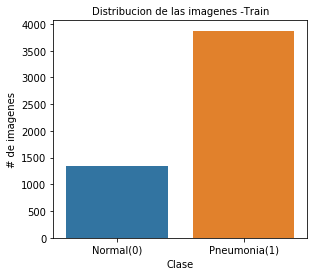

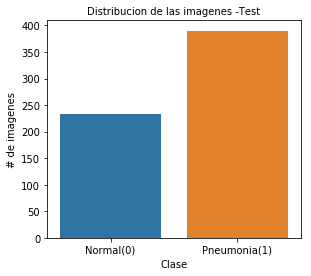

In [6]:
traincount=TRAIN['label'].value_counts()
testcount=TEST['label'].value_counts()
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(x=traincount.index, y= traincount.values)
plt.title('Distribucion de las imagenes -Train', fontsize=10)
plt.xlabel('Clase', fontsize=10)
plt.ylabel('# de imagenes', fontsize=10)
plt.xticks(range(len(traincount.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.figure(figsize=(10,4))
plt.subplot(122)
sns.barplot(x=testcount.index, y= testcount.values)
plt.title('Distribucion de las imagenes -Test', fontsize=10)
plt.xlabel('Clase', fontsize=10)
plt.ylabel('# de imagenes', fontsize=10)
plt.xticks(range(len(testcount.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

### Visualizacion de las imagenes y sus caracteristicas segun la clase.

La neumonía es una enfermedad del sistema respiratorio que consiste en la inflamación de los espacios alveolares de los pulmones que puede afectar a un lóbulo pulmonar completo , a un segmento de lóbulo, a los alvéolos próximos a los bronquios  o al tejido intersticial. La neumonía hace que el tejido que forma los pulmones se vea enrojecido, hinchado, ademas produce liquido en el espacio pulmonar por lo que su deteccion por tecnicas de rayos es posible, normalmente el especialista visualiza manchas de alta intensidad en los pulmones.

*Tomado de eMedicine*

/home/gabriel24/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 5216 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


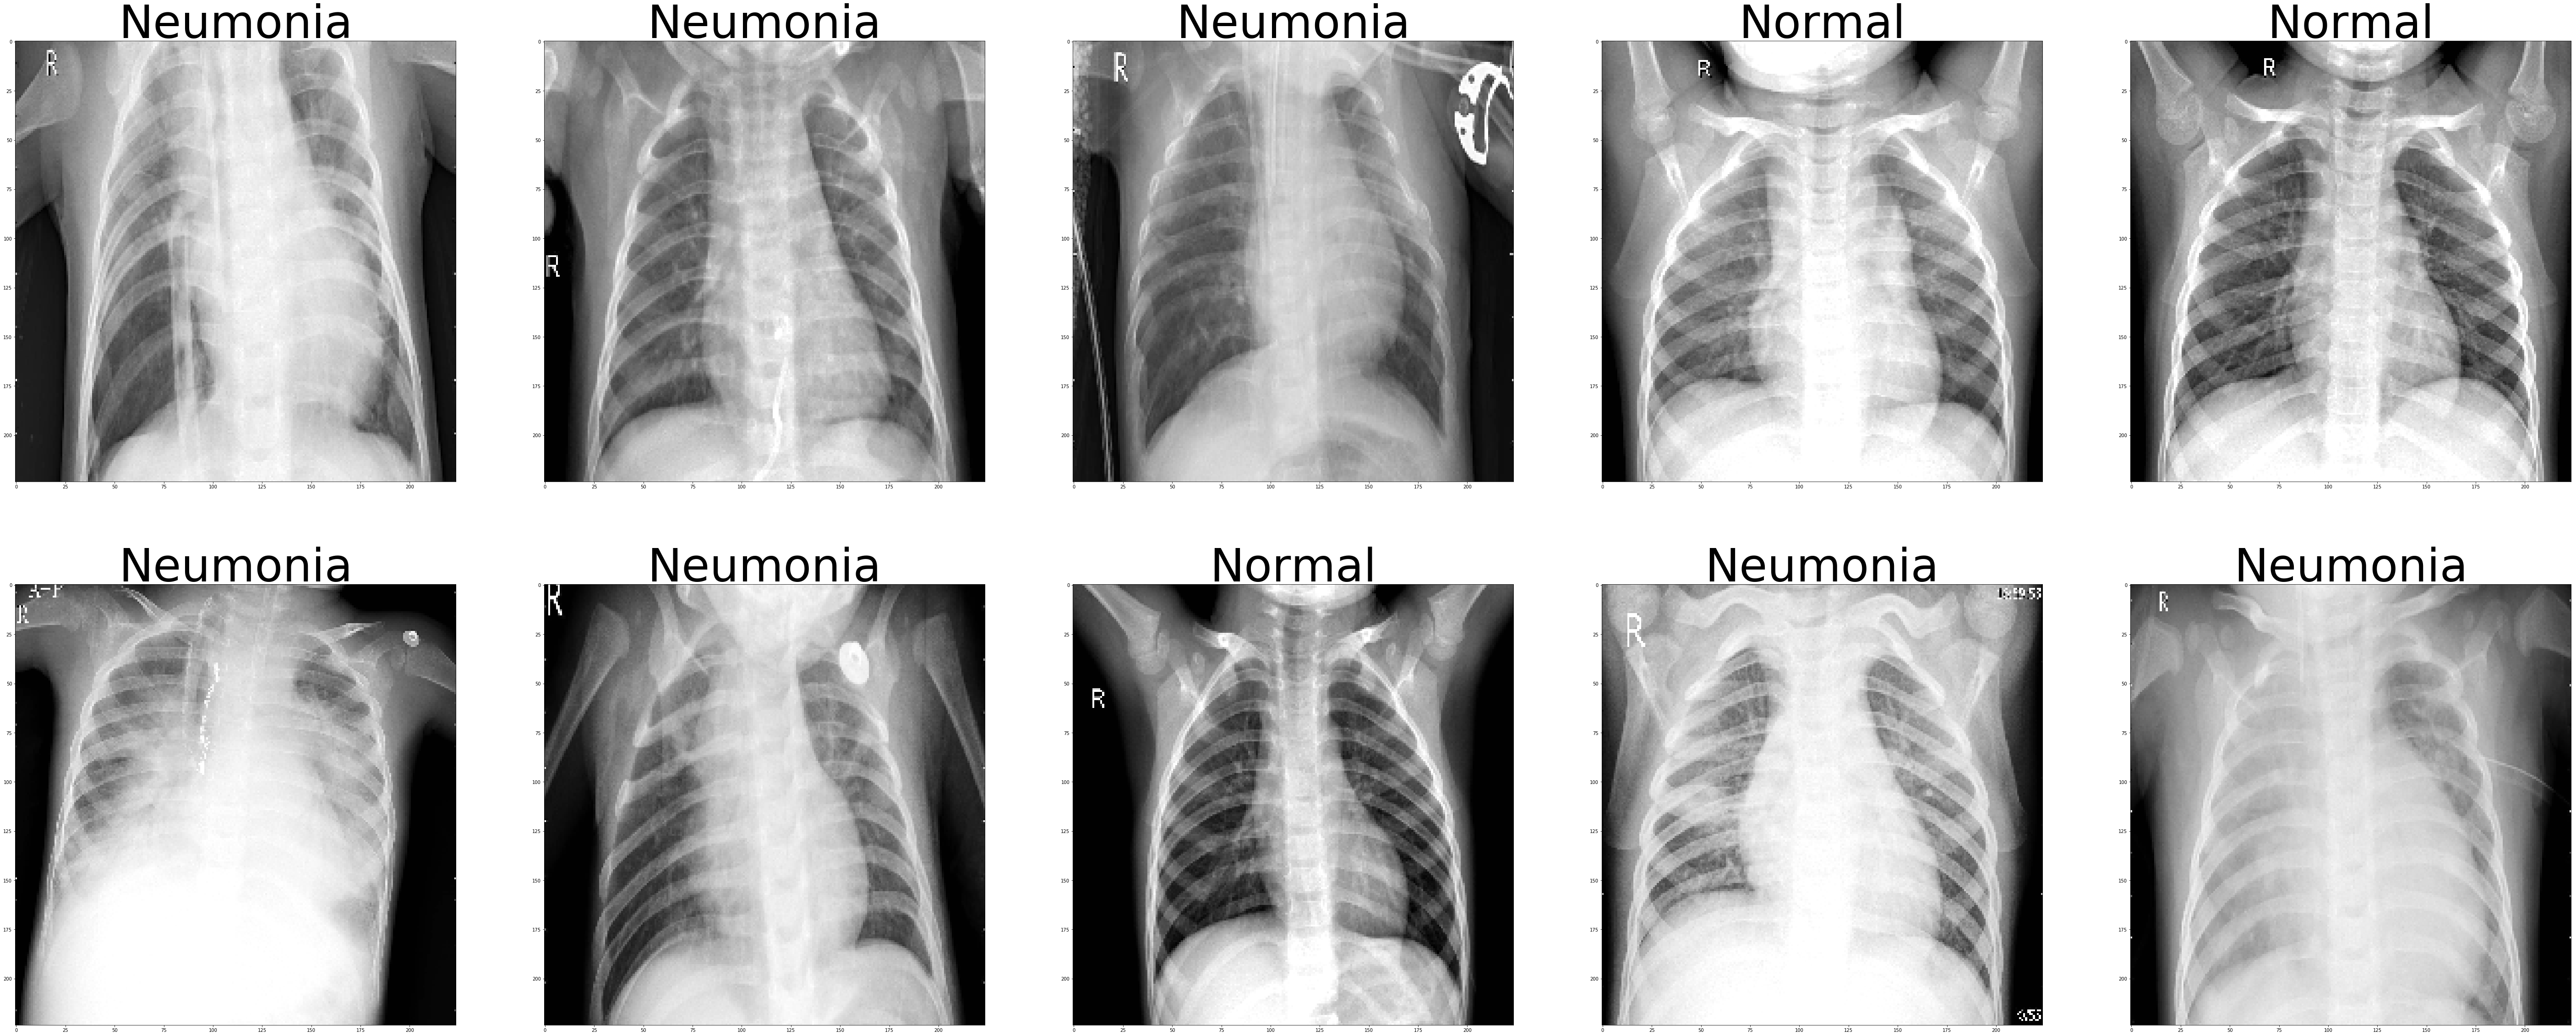

In [9]:
plt.figure(figsize=(100,40))
for i in range(1,11):
    b=np.random.random_integers(5216)
    a=TRAIN['rX'][b]
    #a=cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    c=TRAIN['label'][b]    
    plt.subplot(2,5,i)    
    plt.imshow(a,cmap="gray")
    if c==1:plt.title('Neumonia',fontdict={'fontsize':100}) #get the title property handler  
    else:plt.title('Normal',fontdict={'fontsize':100}) #get the title property handler  
    

# Modelo

A partir de un estudio acerca de varios modelos desarrollados para tareas tales como la clasificación de imágenes, se encontró que uno de los modelos que alcanzan una buena exactitud es el VGG con aproximadamente 71%, el cual está por encima de arquitecturas como Alexnet y googlenet y en temas de costo computacional no es tan compleja como la arquitectura InceptionV4 que alcanza un 80%. 
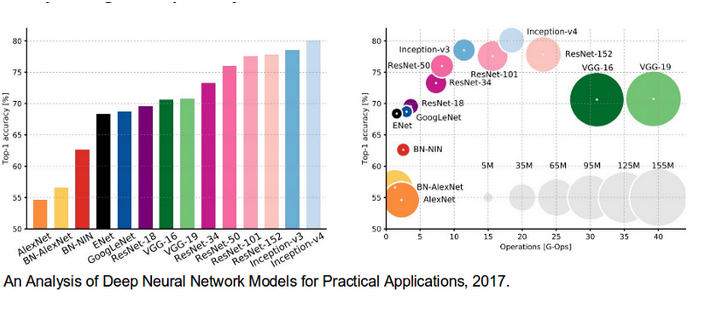
Red: https://www.kaggle.com/keras/vgg16 , https://arxiv.org/pdf/1409.1556.pdf

#### De acuerdo a lo anterior se propone usar transferlearning apartir de la red convolucional  VGG, por lo tanto se crea la arquitectura para posteriormente cargar los pesos.

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import h5py

Using TensorFlow backend.


In [8]:
def get_transfer_model():
    input_img = Input(shape=(224,224,3), name='input')
    layer = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    layer = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(layer)
    layer = MaxPooling2D((2,2), name='pool1')(layer)       
    layer = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(layer)
    layer = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(layer)
    layer = MaxPooling2D((2,2), name='pool2')(layer)    
    layer = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(layer)
    layer = BatchNormalization(name='bn1')(layer)
    layer = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(layer)
    layer = BatchNormalization(name='bn2')(layer)
    layer = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(layer)
    layer = MaxPooling2D((2,2), name='pool3')(layer)    
    layer = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(layer)
    layer = BatchNormalization(name='bn3')(layer)
    layer = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(layer)
    layer = BatchNormalization(name='bn4')(layer)
    layer = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(layer)
    layer = MaxPooling2D((2,2), name='pool4')(layer)    
    layer = Flatten(name='flatten')(layer)
    layer = Dense(1024, activation='relu', name='fc1')(layer)
    layer = Dropout(0.7, name='dropout1')(layer)
    layer = Dense(512, activation='relu', name='fc2')(layer)
    layer = Dropout(0.5, name='dropout2')(layer)
    layer = Dense(2, activation='softmax', name='fc3')(layer)    
    model = Model(inputs=input_img, outputs=layer)
    return model

In [9]:
model =  get_transfer_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableCon

In [11]:
# Cargando los pesos de la red VGG 
weights = h5py.File('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Transfiriendo los pesos a nuestra arquitectura

w,b = weights['block1_conv1']['block1_conv1_W_1:0'], weights['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = weights['block1_conv2']['block1_conv2_W_1:0'], weights['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = weights['block2_conv1']['block2_conv1_W_1:0'], weights['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = weights['block2_conv2']['block2_conv2_W_1:0'], weights['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

weights.close()
model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [62]:
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
check = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

#### Al llamar el FIT, asignamos el parametro class_weigths que nos ayuda a lidiar con el desbalance de las clases.

In [13]:
h=model.fit(x=x_train, y=y_train, batch_size=1, epochs=1, verbose=1, callbacks=[es, check], validation_split=0.0, validation_data=(x_test,y_test), shuffle=True, class_weight={0:1.0, 1:0.4})

Instructions for updating:
Use tf.cast instead.
Train on 5216 samples, validate on 624 samples
Epoch 1/1
5216/5216 [==============================] - 7774s 1s/step - loss: 0.1350 - acc: 0.9055 - val_loss: 1.5379 - val_acc: 0.7420


# Se entreno sobre 5216 muestras y se hizo test sobre 624 muestras para obtener una precision del 90.55% en el set de entrenamiento y 74.2% en el set de test.

### Analizaremos algunas metricas sobre el set de test y finalmente sobre el de validacion para un resultado final insesgado. El set de validacion esta compuesto de  16 imagenes, 8 de cada clase.

In [56]:
from sklearn.metrics import confusion_matrix
y_test_preds=model.predict(x_test)
y_test_preds=np.argmax(y_test_preds, axis=-1)
y_test1=np.argmax(np.array(y_test), axis=-1)

In [59]:
cmtest=confusion_matrix(y_test1,y_test_preds)
cmtest

array([[ 78, 156],
       [  5, 385]])

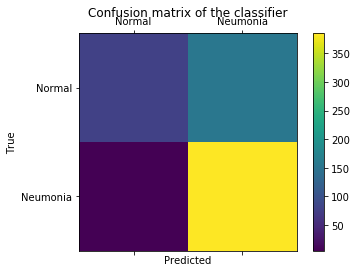

In [60]:
labels = ['Normal', 'Neumonia']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cmtest)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [61]:
tn, fp, fn, tp = cmtest.ravel()
precision = tp*1.0/(tp+fp)
sensibilidad = tp*1.0/(tp+fn)

print("Sensibilidad test:"+ str(sensibilidad))
print("Precision test:"+str(precision))

Sensibilidad test:0.9871794871794872
Precision test:0.711645101663586


In [38]:
y_val_preds=model.predict(x_val)
y_val_preds=np.argmax(y_val_preds, axis=-1)
y_val=np.argmax(np.array(y_val), axis=-1)

In [45]:
a=confusion_matrix(y_val,y_val_preds)
a

array([[3, 5],
       [1, 7]])

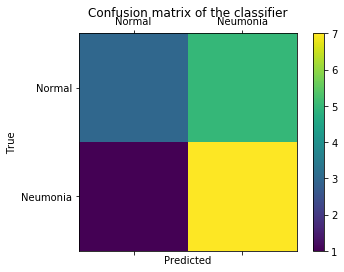

In [44]:
labels = ['Normal', 'Neumonia']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(a)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [55]:
tn, fp, fn, tp = a.ravel()
precision = tp*1.0/(tp+fp)
sensibilidad = tp*1.0/(tp+fn)

print("Sensibilidad:"+ str(sensibilidad))
print("Precision:"+str(precision))

Sensibilidad:0.875
Precision:0.5833333333333334


## Analisis del flujo de trabajo:

A pesar de que el modelo no tuvo un gran desempeño en el set de validacion final(16 imagenes) con respecto a la precision obtenida, debemos resaltar otras metricas que se deben tener en cuenta cuando hablamos de aplicaciones medicas como es la *sensibilidad*, que nos indica la capacidad del modelo de de clasificar las muestras verdaderamente positivas sobre las positivas, en este caso los paciente que poseen neumonia(87.5%).  

Debido a la gran complejidad del modelo, se entreno usando un batch de 1 y 1 epoca con el fin de evitar que la memoria se llenara, por lo que aumentar el numero epocas y el tamaño del batch con mas recursos de computo podria mejorar considerablemente los resultados. Se experimentara con un nuevo flujo de trabajo que ahorre recursos de memoria, y que nos permite utilizar batch mas amplio con el fin de agilizar los entrenamientos.
Ademas debido a que las clases no estan perfectamente equilibradas esto puede representar un factor que lleve al modelo sobreajustarse a la clase *Neumonia*. debido a que esta posee muchas mas muestras.

